In [1]:
import streamlit as st
from google.cloud import bigquery
from datetime import datetime, timezone, timedelta
import seaborn as sns
import pandas as pd
import json
import os

In [2]:
BIGQUERY_PROJECT_NAME = 'oso-data-436717'

In [4]:
with open("streamlit_dashboard/defillama.json", "r") as f:
    defi_llama_protocols = json.load(f)

In [5]:
defi_llama_protocols

{'Expanding restaking on Optimism': 'kelp_dao',
 'Renzo Optimism Season 6 Mission Request - Optimism as base for LRTs': 'renzo',
 'Boosting LRT adoption with Compound Finance': 'compound_finance',
 'TLX - Leveraged Tokens Protocol': 'tlx_finance',
 'OETH on OP (2 of 3)': 'origin_protocol',
 "Let's Get HAI": 'lets_get_hai',
 'Fraxtal Application': 'frax_finance',
 'Derive (Formerly Lyra) Chain - Intent 3B': 'derive',
 'Yield Bearing asset utility with Compound': 'compound_finance',
 'Beefy - mooBIFI': 'beefy',
 'OETH on OP 4': 'origin_protocol',
 'Contango ': 'contango',
 'Velodrome Finance': 'velodrome',
 'Idle - Credit Vaults III': 'idle',
 'dForce on OP (Resubmission II)': 'dforce',
 'Alchemix Grant Request': 'alchemix',
 'Toros Finance': 'toros',
 'Pyth Network: Infrastructure Subsidies': 'pyth_network',
 'Ionic Superchain Borrow/Lend Aggregator': 'ionic_protocol',
 'Pyth Network: Decentralized Solvers (Pyth Express Relay)': 'pyth_network',
 'Derive (Formerly Lyra) Chain - Intent 3B

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
client = bigquery.Client(BIGQUERY_PROJECT_NAME)

In [9]:
def query_protocol(protocol):
    sql_query = f"""
        select
            name,
            chain_tvls,
            tvl,
            tokens_in_usd,
            tokens,
            current_chain_tvls,
            raises,
            metrics,
            mcap
        from `{BIGQUERY_PROJECT_NAME}.defillama_tvl.{protocol}`
    """

    protocol_result = client.query(sql_query)
    protocol_df = protocol_result.to_dataframe()

    return protocol_df

In [7]:
renzo_df = query_protocol('renzo')

In [8]:
pd.DataFrame(json.loads(renzo_df.iloc[0, 6]))

,amount,category,chains,date,defillamaId,leadInvestors,name,otherInvestors,round,sector,source,valuation
0,NaN,Liquid Staking Protocol,[Ethereum],1708560000,3933,[Binance Labs],Renzo,[],Private,Liquid Restaking Hub,https://x.com/BinanceLabs/status/1760666575508...,None
1,17.0,Liquid Staking Protocol,[Ethereum],1718668800,3933,"[Galaxy, Brevan Howard Digital]",Renzo,"[Maven 11, Figment Capital, Protagonist, Seven...",Private,Liquid Restaking Hub,https://x.com/RenzoProtocol/status/18030401964...,None
2,3.2,Liquid Staking Protocol,[Ethereum],1705276800,3933,[Maven 11],Renzo,"[Figment Capital, SevenX Ventures, IOSG Ventur...",Seed,Liquid Restaking Hub,https://x.com/RenzoProtocol/status/17469418246...,25


In [9]:
alchemix_df = query_protocol('alchemix')

In [10]:
alchemix_df.to_csv('metrics/temp_df.csv', index=False)

In [11]:
alchemix_df.columns

Index(['name', 'chain_tvls', 'tvl', 'tokens_in_usd', 'tokens',
       'current_chain_tvls', 'raises', 'metrics', 'mcap'],
      dtype='object')

In [12]:
alchemix_df

,name,chain_tvls,tvl,tokens_in_usd,tokens,current_chain_tvls,raises,metrics,mcap
0,Alchemix,"{""Arbitrum"":{""tokens"":[{""date"":1719705600,""tok...","[{""date"":1637193600,""totalLiquidityUSD"":797748...","[{""date"":1637193600,""tokens"":{""USDT"":0,""USDC"":...","[{""date"":1637193600,""tokens"":{""USDT"":0,""USDC"":...","{""Arbitrum"":919976.81037,""Ethereum"":54373482.3...",[],{},4.745178e+07


In [13]:
def chain_tvls_col_to_df(df):

    chain_tvls = pd.DataFrame(json.loads(df.iloc[0, 1]))

    def normalize_chain_data(chain_name, chain_data):
        records = []
        for entry in chain_data:
            date = entry["date"]
            for token, value in entry["tokens"].items():
                records.append({"chain": chain_name, "date": date, "token": token, "value": value})
        return pd.DataFrame(records)

    all_chains_data = []
    for chain in chain_tvls.columns:
        chain_data = chain_tvls[chain].iloc[0]
        normalized_data = normalize_chain_data(chain, chain_data)
        all_chains_data.append(normalized_data)

    cleaned_df = pd.concat(all_chains_data, ignore_index=True)

    cleaned_df['readable_date'] = cleaned_df['date'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )

    return cleaned_df

In [14]:
chain_tvls = chain_tvls_col_to_df(alchemix_df)

In [15]:
def tvl_col_to_df(df):
    # extract tvl data
    tvl_df = pd.DataFrame(json.loads(df.iloc[0, 2]))
    
    # convert timestamp to a human-readable date
    tvl_df['readable_date'] = tvl_df['date'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )

    return tvl_df

In [16]:
tvl = tvl_col_to_df(alchemix_df)

In [17]:
def tokens_in_usd_col_to_df(df):
    # extract tokens_in_usd data from the column
    tokens_data = pd.DataFrame(json.loads(df.iloc[0, 3]))

    # flatten the tokens dictionary for each date
    records = []
    for _, row in tokens_data.iterrows():
        date = row["date"]
        tokens = row["tokens"]
        for token, value in tokens.items():
            records.append({"date": date, "token": token, "value": value})

    # create a DataFrame from the flattened records
    tokens_df = pd.DataFrame(records)

    # convert timestamp to a human-readable date
    tokens_df['readable_date'] = tokens_df['date'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )

    return tokens_df

In [18]:
tokens_in_usd = tokens_in_usd_col_to_df(alchemix_df)

In [19]:
def tokens_col_to_df(df):
    # extract tokens data from the column
    tokens_data = pd.DataFrame(json.loads(df.iloc[0, 4]))

    # flatten the tokens dictionary for each date
    records = []
    for _, row in tokens_data.iterrows():
        date = row["date"]
        tokens = row["tokens"]
        for token, value in tokens.items():
            records.append({"date": date, "token": token, "value": value})

    # create a DataFrame from the flattened records
    tokens_df = pd.DataFrame(records)

    # convert timestamp to a human-readable date
    tokens_df['readable_date'] = tokens_df['date'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )

    return tokens_df

In [20]:
tokens = tokens_col_to_df(alchemix_df)

In [21]:
print(chain_tvls.columns)
print(tvl.columns)
print(tokens_in_usd.columns)
print(tokens.columns)

Index(['chain', 'date', 'token', 'value', 'readable_date'], dtype='object')
Index(['date', 'totalLiquidityUSD', 'readable_date'], dtype='object')
Index(['date', 'token', 'value', 'readable_date'], dtype='object')
Index(['date', 'token', 'value', 'readable_date'], dtype='object')


In [22]:
chain_tvls['token'].value_counts()

token
DAI         2636
ALCX        2270
WETH        2135
USDT        1835
USDC        1622
WSTETH      1489
RETH        1129
YVDAI        953
YVUSDC       879
YVUSDT       722
YVWETH       700
AOPTWETH     696
AOPTUSDT     696
AOPTUSDC     696
AOPTDAI      696
3CRV         586
USDC.E       430
CRVFRAX      301
VAUSDC       177
VAFRAX       177
VAETH        177
VADAI        177
SFRXETH      177
TWETH         71
FUSDT         23
ETH           14
Name: count, dtype: int64

In [23]:
selected_token = st.selectbox("Select a Token", chain_tvls['token'].unique())

pivoted_chain_tvls = pd.pivot(chain_tvls[chain_tvls['token'] == selected_token], index='readable_date', columns='chain', values='value')

st.line_chart(pivoted_chain_tvls)

2024-12-25 20:35:32.649 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 20:35:32.650 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 20:35:32.652 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 20:35:32.653 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 20:35:32.654 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2024-12-25 20:35:32.655 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

DeltaGenerator()

In [24]:
chain_tvls[chain_tvls['token'] == "ETH"]

,chain,date,token,value,readable_date
14239,Optimism,1667952000,ETH,8.69234,2022-11-09 00:00:00
14244,Optimism,1668038400,ETH,8.79216,2022-11-10 00:00:00
14249,Optimism,1668124800,ETH,8.80404,2022-11-11 00:00:00
14254,Optimism,1668211200,ETH,8.80404,2022-11-12 00:00:00
14259,Optimism,1668297600,ETH,9.44705,2022-11-13 00:00:00
14264,Optimism,1668384000,ETH,9.44705,2022-11-14 00:00:00
14269,Optimism,1668470400,ETH,9.49855,2022-11-15 00:00:00
14274,Optimism,1668556800,ETH,9.51061,2022-11-16 00:00:00
14279,Optimism,1668643200,ETH,9.51061,2022-11-17 00:00:00
14284,Optimism,1668729600,ETH,9.81061,2022-11-18 00:00:00


In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

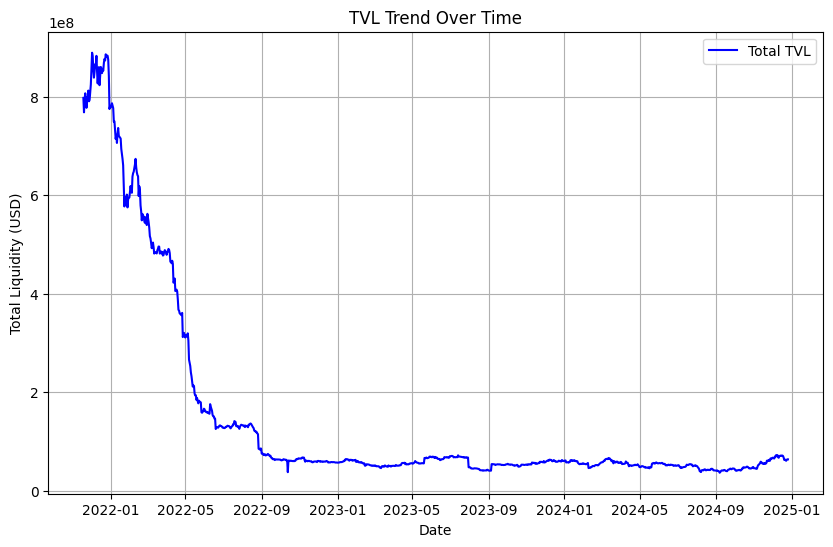

In [29]:
# Load and preprocess data
tvl['readable_date'] = pd.to_datetime(tvl['readable_date'])
tvl = tvl.sort_values(by='readable_date')

# Plot TVL trend over time
plt.figure(figsize=(10, 6))
plt.plot(tvl['readable_date'], tvl['totalLiquidityUSD'], label='Total TVL', color='blue')
plt.title('TVL Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Liquidity (USD)')
plt.legend()
plt.grid()
plt.show()

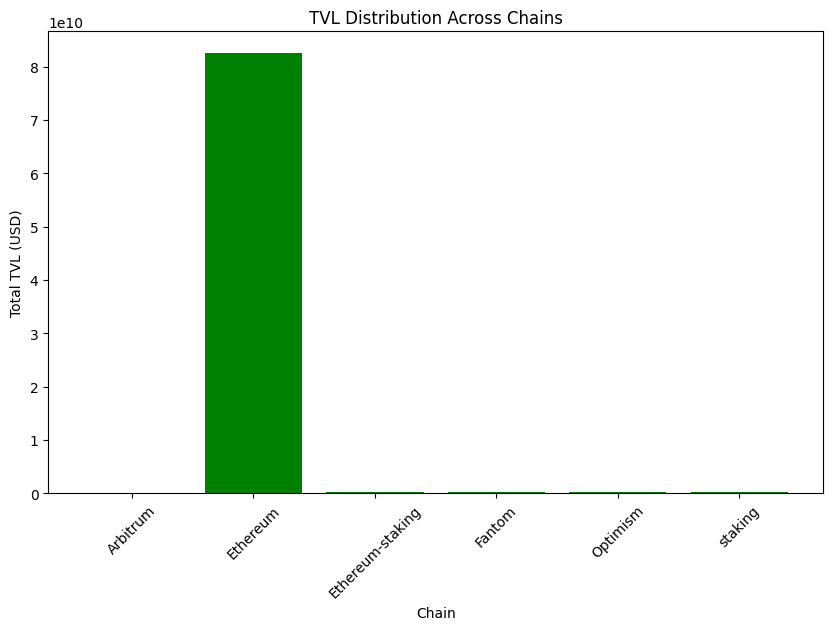

In [30]:
# Aggregate TVL by chain
chain_tvl_summary = chain_tvls.groupby('chain')['value'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(chain_tvl_summary['chain'], chain_tvl_summary['value'], color='green')
plt.title('TVL Distribution Across Chains')
plt.xlabel('Chain')
plt.ylabel('Total TVL (USD)')
plt.xticks(rotation=45)
plt.show()


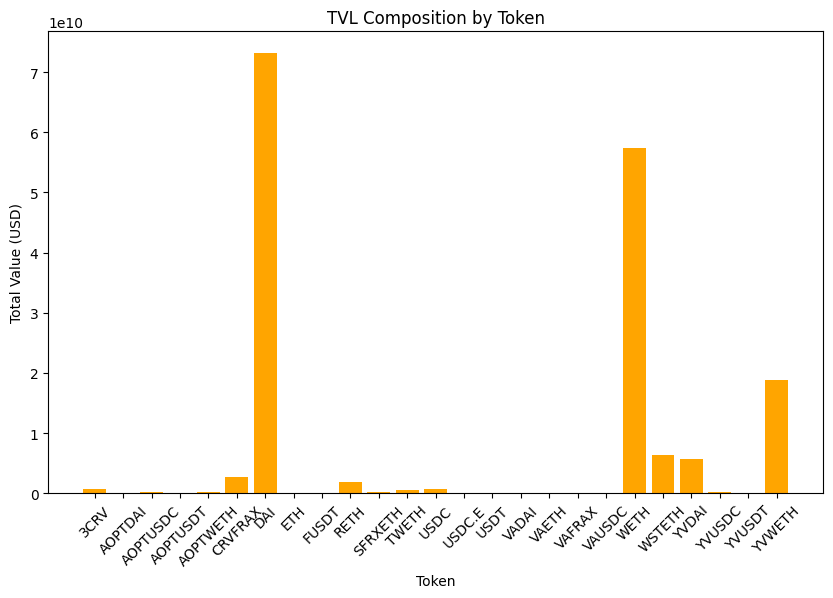

In [31]:
# Aggregate TVL by token
token_tvl_summary = tokens_in_usd.groupby('token')['value'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(token_tvl_summary['token'], token_tvl_summary['value'], color='orange')
plt.title('TVL Composition by Token')
plt.xlabel('Token')
plt.ylabel('Total Value (USD)')
plt.xticks(rotation=45)
plt.show()

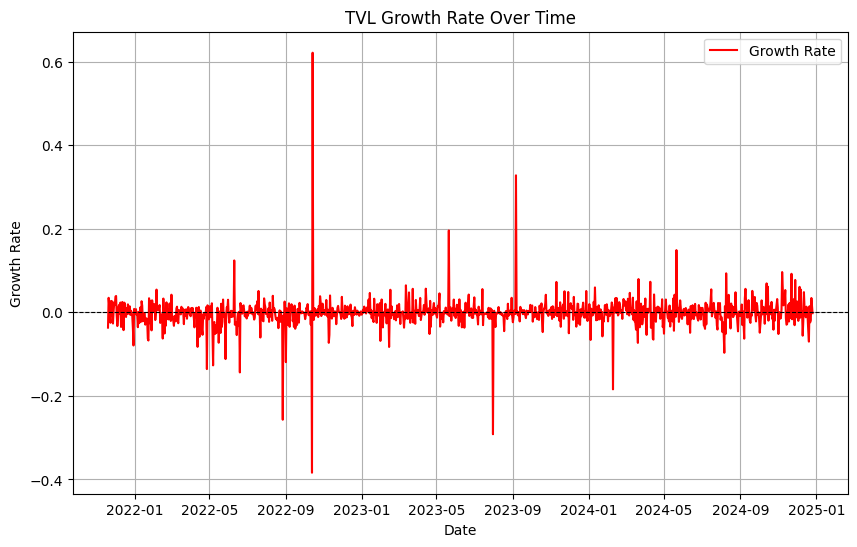

In [32]:
# Calculate growth rate
tvl['tvl_diff'] = tvl['totalLiquidityUSD'].diff()
tvl['tvl_growth_rate'] = tvl['tvl_diff'] / tvl['totalLiquidityUSD'].shift(1)

# Plot TVL growth rate
plt.figure(figsize=(10, 6))
plt.plot(tvl['readable_date'], tvl['tvl_growth_rate'], label='Growth Rate', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('TVL Growth Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Growth Rate')
plt.legend()
plt.grid()
plt.show()

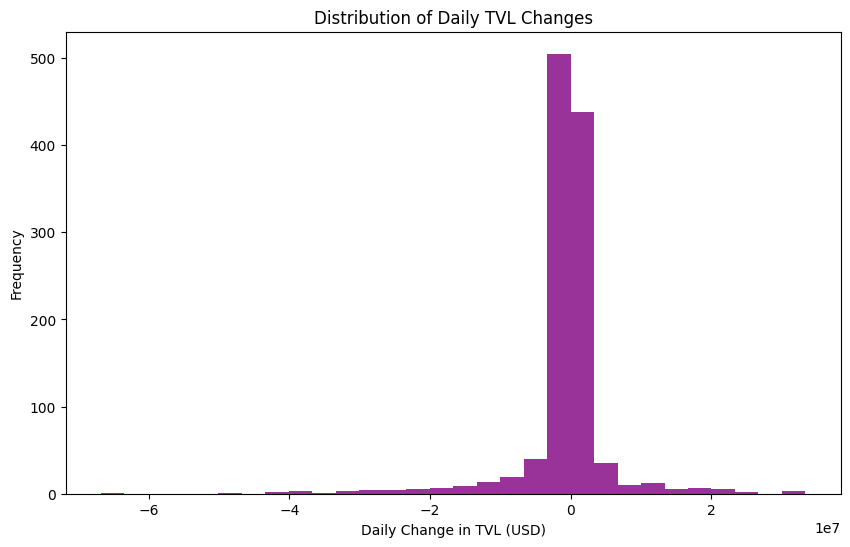

In [34]:
# Calculate daily TVL changes
tvl['tvl_diff'] = tvl['totalLiquidityUSD'].diff()

# Plot histogram of daily changes
plt.figure(figsize=(10, 6))
plt.hist(tvl['tvl_diff'].dropna(), bins=30, color='purple', alpha=0.8)
plt.title('Distribution of Daily TVL Changes')
plt.xlabel('Daily Change in TVL (USD)')
plt.ylabel('Frequency')
plt.show()

In [43]:
chain_tvls

,chain,date,token,value,readable_date
0,Arbitrum,1719705600,USDC,313.57898,2024-06-30 00:00:00
1,Arbitrum,1719705600,WETH,1.42010,2024-06-30 00:00:00
2,Arbitrum,1719792000,USDC,34.75763,2024-07-01 00:00:00
3,Arbitrum,1719792000,WETH,1.42010,2024-07-01 00:00:00
4,Arbitrum,1719878400,USDC,125.93226,2024-07-02 00:00:00
...,...,...,...,...,...
21459,staking,1734825600,ALCX,275590.34822,2024-12-22 00:00:00
21460,staking,1734912000,ALCX,275359.25329,2024-12-23 00:00:00
21461,staking,1734998400,ALCX,275159.25329,2024-12-24 00:00:00
21462,staking,1735084800,ALCX,275063.86319,2024-12-25 00:00:00


In [59]:
chain_tvls['daily_change'] = chain_tvls.groupby(['chain', 'token'])['value'].diff()
chain_tvls.dropna(subset='daily_change', inplace=True)

In [60]:
chain_tvls

,chain,date,token,value,readable_date,daily_change
6,Arbitrum,1719964800,USDC,232.60691,2024-07-03 00:00:00,106.67465
7,Arbitrum,1719964800,WETH,1.49977,2024-07-03 00:00:00,0.00000
9,Arbitrum,1720051200,USDC,232.60691,2024-07-04 00:00:00,0.00000
10,Arbitrum,1720051200,WETH,1.49977,2024-07-04 00:00:00,0.00000
12,Arbitrum,1720137600,USDC,326.86548,2024-07-05 00:00:00,94.25857
...,...,...,...,...,...,...
21459,staking,1734825600,ALCX,275590.34822,2024-12-22 00:00:00,-33.39919
21460,staking,1734912000,ALCX,275359.25329,2024-12-23 00:00:00,-231.09493
21461,staking,1734998400,ALCX,275159.25329,2024-12-24 00:00:00,-200.00000
21462,staking,1735084800,ALCX,275063.86319,2024-12-25 00:00:00,-95.39010


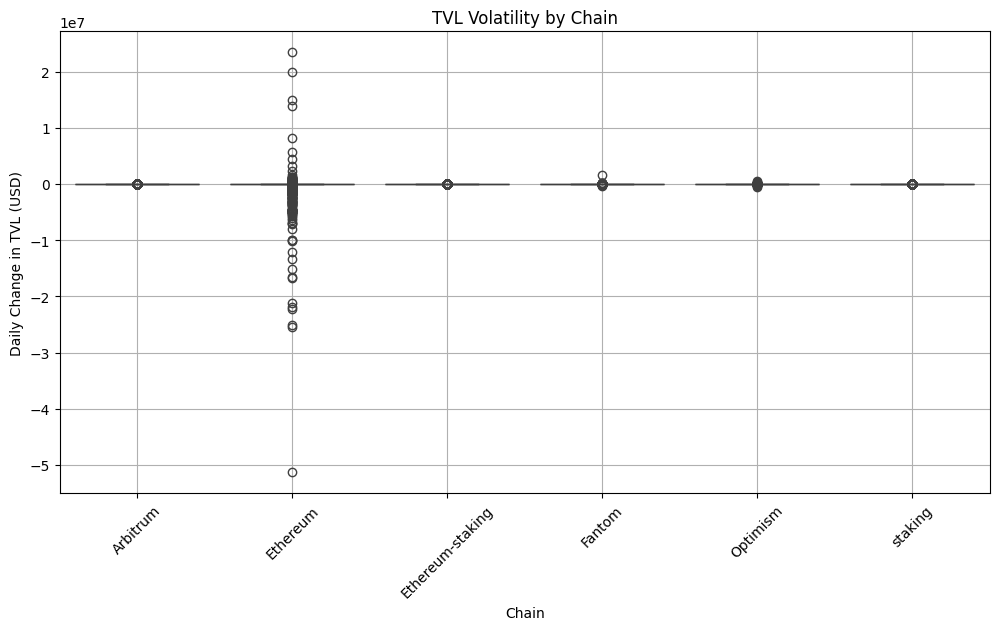

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=chain_tvls, x='chain', y='daily_change')
plt.title('TVL Volatility by Chain')
plt.xlabel('Chain')
plt.ylabel('Daily Change in TVL (USD)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [11]:
temp_df = pd.read_csv('streamlit_dashboard/temp_df.csv')

In [12]:
temp_df

,name,chain_tvls,tvl,tokens_in_usd,tokens,current_chain_tvls,raises,metrics,mcap
0,Alchemix,"{""Arbitrum"":{""tokens"":[{""date"":1719705600,""tok...","[{""date"":1637193600,""totalLiquidityUSD"":797748...","[{""date"":1637193600,""tokens"":{""USDT"":0,""USDC"":...","[{""date"":1637193600,""tokens"":{""USDT"":0,""USDC"":...","{""Arbitrum"":919976.81037,""Ethereum"":54373482.3...",[],{},4.745178e+07


In [4]:
alchemix_project = {
    "round": "Grants Season 6",
    "cycle": "Cycle 28",
    "project_name": "Alchemix Grant Request",
    "status": "Passed",
    "proposal_link": "https://app.charmverse.io/op-grants/alchemix-grant-request-90710470226371",
    "amount": 50000,
    "amount_comment": None,
    "meta": {
      "Intent": "Intent 3A",
      "Incentive Program Launched?": "Growth"
    },
    "relevant_metrics": {
      "select the metric specified in the mission request": "(Intent 3 Growth) TVL in grantee\u2019s protocol",
      "fill out your metric objective": "Increase in TVL of 1320 ETH in the wstETH vault (~50%), depending on OP/ETH price fluctuation. "
    },
    "relevant_dates": {
      "OP deployment date": [
        "Sep 27, 2022"
      ],
      "Incentives due date": [
        "Oct 31"
      ]
    },
    "relevant_chains": [
      "op"
    ],
    "contract_urls": [],
    "addresses": [
      {
        "0x8cca517370cbfc33cc9810bfc7440832c47d251c": {
          "networks": [
            "optimism"
          ],
          "tags": [
            "wallet"
          ],
          "count_txns": 1
        }
      },
      {
        "0x8cca517370cbfc33cc9810bfc7440832c47d251c": {
          "networks": [
            "optimism"
          ],
          "tags": [
            "contract"
          ],
          "count_txns": 1
        }
      },
      {
        "0xe04bb5b4de60fa2fba69a93ade13a8b3b569d5b4": {
          "networks": [
            "mainnet",
            "optimism"
          ],
          "tags": [
            "contract"
          ],
          "name": "alchemix",
          "count_txns": 2632
        }
      },
      {
        "0x343910697c03477e5cc0d386ffa5133d1a827ad7": {
          "networks": [
            "optimism"
          ],
          "tags": [
            "contract"
          ],
          "name": "alchemix",
          "count_txns": 0
        }
      },
      {
        "0xc224bf25dcc99236f00843c7d8c4194abe8aa94a": {
          "networks": [
            "optimism"
          ],
          "tags": [
            "safe",
            "wallet"
          ],
          "name": "alchemix",
          "count_txns": 37
        }
      }
    ]
  }

In [5]:
PROJECT_NETWORK = 'mainnet'

def query_transactions_min_date(client, project_addresses, start_date) -> pd.DataFrame:
    try:
        # handle single or multiple addresses in the query
        if len(project_addresses) == 1:
            addresses_condition = f"= '{project_addresses[0]}'"
        else:
            addresses_condition = f"IN {tuple(project_addresses)}"

        min_date_query = f"""
        SELECT MIN(dt) AS transaction_date
        FROM `{BIGQUERY_PROJECT_NAME}.optimism_superchain_raw_onchain_data.transactions`
        WHERE network = '{PROJECT_NETWORK}'
            AND (to_address {addresses_condition}
            OR from_address {addresses_condition})
            AND dt >= '{start_date}'
        """

        min_date_result = client.query(min_date_query)
        min_date_df = min_date_result.to_dataframe()

        if not min_date_df.empty and min_date_df.loc[0, 'transaction_date']:
            return pd.to_datetime(min_date_df.loc[0, 'transaction_date'])

    except Exception as e:
        print(f"Error querying minimum transaction date: {e}")

    return None

In [42]:
from streamlit_dashboard.single_project_visualizations import process_project, generate_dates, extract_addresses
from streamlit_dashboard.defi_llama_visualizations import process_protocol
import numpy as np
from scipy.stats import t

In [7]:
GRANT_DATE = datetime(2024, 9, 1)
time_since_interval = datetime.today() - GRANT_DATE
min_start = GRANT_DATE - time_since_interval
min_start_string = min_start.strftime('%Y-%m-%d')

project_addresses = extract_addresses(alchemix_project)
transactions_min_date = query_transactions_min_date(client, project_addresses, min_start_string)

# ensure transactions_min_date is valid before comparison
if transactions_min_date is not None:
    min_start = max(transactions_min_date, min_start)

min_start_string = min_start.strftime('%Y-%m-%d')

dates = generate_dates(min_start)

daily_transactions, op_flow, net_op_flow = process_project(client, project_addresses, dates, min_start_string)
chain_tvls_df, tvl_df, tokens_in_usd_df, tokens_df = process_protocol("alchemix")

In [27]:
daily_transactions = daily_transactions.drop_duplicates(subset=['transaction_date', 'address']).reset_index(drop=True)

In [28]:
import os

output_directory = "streamlit_dashboard/"
os.makedirs(output_directory, exist_ok=True)

file_paths = {
    "daily_transactions": os.path.join(output_directory, "daily_transactions.csv"),
    "op_flow": os.path.join(output_directory, "op_flow.csv"),
    "net_op_flow": os.path.join(output_directory, "net_op_flow.csv"),
    "chain_tvls_df": os.path.join(output_directory, "chain_tvls_df.csv"),
    "tvl_df": os.path.join(output_directory, "tvl_df.csv"),
    "tokens_in_usd_df": os.path.join(output_directory, "tokens_in_usd_df.csv"),
    "tokens_df": os.path.join(output_directory, "tokens_df.csv"),
}

daily_transactions.to_csv(file_paths["daily_transactions"], index=False)
op_flow.to_csv(file_paths["op_flow"], index=False)
net_op_flow.to_csv(file_paths["net_op_flow"], index=False)
chain_tvls_df.to_csv(file_paths["chain_tvls_df"], index=False)
tvl_df.to_csv(file_paths["tvl_df"], index=False)
tokens_in_usd_df.to_csv(file_paths["tokens_in_usd_df"], index=False)
tokens_df.to_csv(file_paths["tokens_df"], index=False)

In [93]:
def split_dataset(dataset, grant_date):
    date_col = 'transaction_date' if 'transaction_date' in dataset.columns else 'readable_date'

    # ensure the date column is in datetime format
    dataset[date_col] = pd.to_datetime(dataset[date_col])

    # determine the minimum date in the dataset
    min_date = dataset[date_col].min()

    # calculate the time duration since the grant
    time_since_grant = datetime.today() - grant_date

    # calculate the target start date for the pre-grant dataset
    pre_grant_start_date = grant_date - time_since_grant

    # ensure the pre-grant start date does not precede the dataset's minimum date
    pre_grant_start_date = max(pre_grant_start_date, min_date)

    # split the dataset
    pre_grant_df = dataset[(dataset[date_col] < grant_date) & (dataset[date_col] >= pre_grant_start_date)]
    post_grant_df = dataset[dataset[date_col] >= grant_date]

    return pre_grant_df, post_grant_df

datasets = [
    daily_transactions,
    op_flow,
    net_op_flow,
    chain_tvls_df,
    tvl_df,
    tokens_in_usd_df,
    tokens_df
]

split_datasets = []
for df in datasets:
    split_df = split_dataset(df, GRANT_DATE)
    split_datasets.append(split_df)

In [94]:
for s, t in split_datasets:
    print(s)

    transaction_date                                     address  \
1         2024-05-06  0xe04bb5b4de60fa2fba69a93ade13a8b3b569d5b4   
2         2024-05-07  0xc224bf25dcc99236f00843c7d8c4194abe8aa94a   
3         2024-05-08  0x343910697c03477e5cc0d386ffa5133d1a827ad7   
4         2024-05-08  0xc224bf25dcc99236f00843c7d8c4194abe8aa94a   
5         2024-05-08  0xe04bb5b4de60fa2fba69a93ade13a8b3b569d5b4   
..               ...                                         ...   
622       2024-08-30  0x343910697c03477e5cc0d386ffa5133d1a827ad7   
623       2024-08-30  0x8cca517370cbfc33cc9810bfc7440832c47d251c   
624       2024-08-31  0x343910697c03477e5cc0d386ffa5133d1a827ad7   
625       2024-08-31  0x8cca517370cbfc33cc9810bfc7440832c47d251c   
626       2024-08-31  0xc224bf25dcc99236f00843c7d8c4194abe8aa94a   

     transaction_cnt  active_users  total_op_transferred  unique_users  \
1                  1             1                     0             1   
2                  3             1 

In [95]:
split_datasets[0][0]

,transaction_date,address,transaction_cnt,active_users,total_op_transferred,unique_users,total_op_transferred_in_tokens
1,2024-05-06,0xe04bb5b4de60fa2fba69a93ade13a8b3b569d5b4,1,1,0,1,0.0
2,2024-05-07,0xc224bf25dcc99236f00843c7d8c4194abe8aa94a,3,1,0,1,0.0
3,2024-05-08,0x343910697c03477e5cc0d386ffa5133d1a827ad7,2,1,0,1,0.0
4,2024-05-08,0xc224bf25dcc99236f00843c7d8c4194abe8aa94a,1,1,0,0,0.0
5,2024-05-08,0xe04bb5b4de60fa2fba69a93ade13a8b3b569d5b4,9,3,0,3,0.0
...,...,...,...,...,...,...,...
622,2024-08-30,0x343910697c03477e5cc0d386ffa5133d1a827ad7,0,0,0,0,0.0
623,2024-08-30,0x8cca517370cbfc33cc9810bfc7440832c47d251c,0,0,0,0,0.0
624,2024-08-31,0x343910697c03477e5cc0d386ffa5133d1a827ad7,0,0,0,0,0.0
625,2024-08-31,0x8cca517370cbfc33cc9810bfc7440832c47d251c,0,0,0,0,0.0


In [96]:
pre_grant_daily_sums = split_datasets[0][0].groupby('transaction_date').agg({
    'transaction_cnt': 'sum',
    'active_users': 'sum',
    'unique_users': 'sum',
    'total_op_transferred_in_tokens': 'sum'
}).reset_index()

pre_grant_metrics = pre_grant_daily_sums.agg({
    'transaction_cnt': ['count', 'mean', 'std', 'var'],
    'active_users': ['count', 'mean', 'std', 'var'],
    'unique_users': ['count', 'mean', 'std', 'var'],
    'total_op_transferred_in_tokens': ['count', 'mean', 'std', 'var'],
})

post_grant_daily_sums = split_datasets[0][1].groupby('transaction_date').agg({
    'transaction_cnt': 'sum',
    'active_users': 'sum',
    'unique_users': 'sum',
    'total_op_transferred_in_tokens': 'sum'
}).reset_index()

post_grant_metrics = post_grant_daily_sums.agg({
    'transaction_cnt': ['count', 'mean', 'std', 'var'],
    'active_users': ['count', 'mean', 'std', 'var'],
    'unique_users': ['count', 'mean', 'std', 'var'],
    'total_op_transferred_in_tokens': ['count', 'mean', 'std', 'var'],
})

In [97]:
pre_grant_metrics

,transaction_cnt,active_users,unique_users,total_op_transferred_in_tokens
count,118.000000,118.000000,118.000000,118.0
mean,409.872881,119.118644,70.135593,0.0
std,791.512547,206.154998,161.937833,0.0
var,626492.111908,42499.883239,26223.861799,0.0


In [98]:
post_grant_metrics

,transaction_cnt,active_users,unique_users,total_op_transferred_in_tokens
count,118.000000,118.000000,118.000000,118.000000
mean,25.923729,12.364407,2.076271,0.169492
std,16.573667,6.867072,2.407811,1.841149
var,274.686441,47.156671,5.797552,3.389831


In [99]:
post_grant_metrics[['transaction_cnt']]

,transaction_cnt
count,118.000000
mean,25.923729
std,16.573667
var,274.686441


In [100]:
net_op_flow

,transaction_date,address,direction,cnt,total_op_transferred,total_op_transferred_in_tokens,cum_op_transferred,cum_op_transferred_in_tokens
6295,2024-06-29,0x00000039d07ce382d8d89fd144033869633d278e,in,4,0,0.0,0,0.0
3855,2024-06-22,0x0000022b34b7981427bbd34e9716c543eab7eb18,in,3,0,0.0,0,0.0
7501,2024-07-02,0x00000bec592ec7c143c73dc85804962075827ecc,in,4,0,0.0,0,0.0
3856,2024-06-22,0x00039eac3a861ca6f2a1d842ddfa473d41727c1b,in,6,0,0.0,0,0.0
6620,2024-06-30,0x0008bb335a71a97ae89cf99388d7be70d7ef4660,in,4,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
7237,2024-06-30,0xfff44b511a4c7067b957545b834069ab5b96bac0,in,7,0,0.0,0,0.0
4281,2024-06-22,0xfff48b7706f20b0136865c0285faf8ff4419b69b,in,4,0,0.0,0,0.0
4915,2024-06-23,0xfffe258dddc291fac973a88b9ec2dee8f3b6eb00,in,3,0,0.0,0,0.0
15595,2024-12-07,0xfffe258dddc291fac973a88b9ec2dee8f3b6eb00,in,1,0,0.0,0,0.0


In [101]:
split_datasets.append(split_dataset(net_op_flow, GRANT_DATE))

In [127]:
chain_tvls_df

,chain,date,token,value,readable_date
0,Arbitrum,1719705600,USDC,313.57898,2024-06-30 00:00:00
1,Arbitrum,1719705600,WETH,1.42010,2024-06-30 00:00:00
2,Arbitrum,1719792000,USDC,34.75763,2024-07-01 00:00:00
3,Arbitrum,1719792000,WETH,1.42010,2024-07-01 00:00:00
4,Arbitrum,1719878400,USDC,125.93226,2024-07-02 00:00:00
...,...,...,...,...,...
21459,staking,1734825600,ALCX,275590.34822,2024-12-22 00:00:00
21460,staking,1734912000,ALCX,275359.25329,2024-12-23 00:00:00
21461,staking,1734998400,ALCX,275159.25329,2024-12-24 00:00:00
21462,staking,1735084800,ALCX,275063.86319,2024-12-25 00:00:00


In [128]:
project_addresses

('0x8cca517370cbfc33cc9810bfc7440832c47d251c',
 '0x8cca517370cbfc33cc9810bfc7440832c47d251c',
 '0xe04bb5b4de60fa2fba69a93ade13a8b3b569d5b4',
 '0x343910697c03477e5cc0d386ffa5133d1a827ad7',
 '0xc224bf25dcc99236f00843c7d8c4194abe8aa94a')

In [ ]:
chain_tvls_df, tvl_df, tokens_in_usd_df, tokens_df

In [116]:
def aggregate_metrics(split_datasets, metrics):
    aggregated_metrics = []

    for pre_grant_df, post_grant_df in split_datasets:
        select_metrics = [metric for metric in metrics if metric in pre_grant_df.columns]

        agg_pre_grant_df, agg_post_grant_df = None, None

        # aggregate by metric for pre- and post-grant DataFrames
        for metric in select_metrics:
            curr_pre_agg = pre_grant_df.groupby('transaction_date')[metric].sum().reset_index()
            if agg_pre_grant_df is not None:
                agg_pre_grant_df = agg_pre_grant_df.merge(curr_pre_agg, on='transaction_date', how='inner')
            else:
                agg_pre_grant_df = curr_pre_agg

            curr_post_agg = post_grant_df.groupby('transaction_date')[metric].sum().reset_index()
            if agg_post_grant_df is not None:
                agg_post_grant_df = agg_post_grant_df.merge(curr_post_agg, on='transaction_date', how='inner')
            else:
                agg_post_grant_df = curr_post_agg

        # calculate aggregate statistics ['count', 'mean', 'std', 'var']
        if agg_pre_grant_df is not None:
            pre_grant_stats = agg_pre_grant_df[select_metrics].agg(['count', 'mean', 'std', 'var']).transpose()
        else:
            pre_grant_stats = pd.DataFrame()

        if agg_post_grant_df is not None:
            post_grant_stats = agg_post_grant_df[select_metrics].agg(['count', 'mean', 'std', 'var']).transpose()
        else:
            post_grant_stats = pd.DataFrame()

        aggregated_metrics.append((pre_grant_stats, post_grant_stats))

    return aggregated_metrics

In [119]:
target_metrics = ['transaction_cnt', 'active_users', 'unique_users', 'total_op_transferred_in_tokens', 'cum_op_transferred_in_tokens']

aggregated_metrics = aggregate_metrics(split_datasets, target_metrics)

['transaction_cnt', 'active_users', 'unique_users', 'total_op_transferred_in_tokens']
Index(['transaction_date', 'address', 'transaction_cnt', 'active_users',
       'total_op_transferred', 'unique_users',
       'total_op_transferred_in_tokens'],
      dtype='object')
Index(['transaction_date', 'address', 'transaction_cnt', 'active_users',
       'total_op_transferred', 'unique_users',
       'total_op_transferred_in_tokens'],
      dtype='object')

['total_op_transferred_in_tokens']
Index(['transaction_date', 'from_address', 'to_address', 'cnt',
       'total_op_transferred', 'total_op_transferred_in_tokens', 'direction'],
      dtype='object')
Index(['transaction_date', 'from_address', 'to_address', 'cnt',
       'total_op_transferred', 'total_op_transferred_in_tokens', 'direction'],
      dtype='object')

['total_op_transferred_in_tokens', 'cum_op_transferred_in_tokens']
Index(['transaction_date', 'address', 'direction', 'cnt',
       'total_op_transferred', 'total_op_transferred_i

In [123]:
aggregated_metrics[1][0]

,count,mean,std,var
total_op_transferred_in_tokens,112.0,0.0,0.0,0.0


In [115]:
aggregated_metrics[2][0]

,count,mean,std,var
total_op_transferred_in_tokens,112.0,0.0,0.0,0.0
cum_op_transferred_in_tokens,112.0,0.0,0.0,0.0


In [43]:
# 2-sample hypothesis test
def test_statistic(sample1, sample2):
    # define our constants
    mu1, mu2 = sample1['mean'], sample2['mean']
    n1, n2 = sample1['count'], sample2['count']
    s1_squared, s2_squared = sample1['var'], sample2['var']

    # determine if we can consider variances to be equal
    var_ratio = sample1['var'] / sample2['var']
    if var_ratio <= 2 and var_ratio >= 0.5:
        # variances equal so use students t-test (pooled variance)
        s_pooled_squared = ((n1 - 1) * s1_squared + (n2 - 1) * s2_squared) / (n1 + n2 - 2)
        t_stat = (mu1 - mu2) / s_pooled_squared * np.sqrt((1/n1) + (1/n2))
        df = n1 + n2 - 2
        
    else:
        # variances not equal so use welch's t
        t_stat = (mu1 - mu2) / np.sqrt((s1_squared/n1) + (s2_squared/n2))
        df = (((s1_squared / n1) + (s2_squared / n2))**2) / ((((s1_squared/n1)**2)/(n1-1)) + (((s2_squared/n2)**2)/(n2-1)))

    return t_stat, df

# function to calculate p-value
def t_test(t_stat, df):
    # calculate the two-tailed p-value
    p_value = 2 * (1 - t.cdf(abs(t_stat), df))

    return p_value

In [59]:
t_stat, df = test_statistic(pre_grant_metrics['transaction_cnt'], post_grant_metrics['transaction_cnt'])
t_test(t_stat, df)

np.float64(6.350996692994215e-07)

In [62]:
def determine_statistics(sample1_df, sample2_df):

    metric_table = []

    for metric in sample2_df.columns:
        # calculate t-statistic and degrees of freedom
        t_stat, df = test_statistic(sample1_df[metric], sample2_df[metric])

        # handle division by zero in percent_change
        sample1_grant_mean = sample1_df[metric]['mean']
        sample2_grant_mean = sample2_df[metric]['mean']
        if sample1_grant_mean != 0:
            percent_change = round(((sample2_grant_mean - sample1_grant_mean) / sample1_grant_mean), 4)
        else:
            percent_change = None  # assign None to avoid division by zero

        # append the metric details to the metric_table
        metric_dict = {
            'metric': metric,
            'pre_grant_n' : round(sample1_df[metric]['count'] , 4),
            'pre_grant_mean': round(sample1_grant_mean, 4),
            'pre_grant_std': round(sample1_df[metric]['std'], 4),
            'post_grant_n' : round(sample2_df[metric]['count'] , 4),
            'post_grant_mean': round(sample2_grant_mean, 4),
            'post_grant_std': round(sample2_df[metric]['std'], 4),
            'percent_change': percent_change,
            'test_statistic': round(t_stat, 4),
            'degrees_of_freedom': round(df, 4),
            'p_value': round(t_test(t_stat, df), 4)
        }

        metric_table.append(metric_dict)

    # convert to a dataframe
    return pd.DataFrame(metric_table)

In [63]:
metrics_table = determine_statistics(pre_grant_metrics, post_grant_metrics)

metrics_table

,metric,pre_grant_n,pre_grant_mean,pre_grant_std,post_grant_n,post_grant_mean,post_grant_std,percent_change,test_statistic,degrees_of_freedom,p_value
0,transaction_cnt,118.0,409.8729,791.5125,118.0,25.9237,16.5737,-0.9368,5.2682,117.1026,0.0000
1,active_users,118.0,119.1186,206.1550,118.0,12.3644,6.8671,-0.8962,5.6220,117.2596,0.0000
2,unique_users,118.0,70.1356,161.9378,118.0,2.0763,2.4078,-0.9704,4.5649,117.0517,0.0000
3,total_op_transferred_in_tokens,118.0,0.0000,0.0000,118.0,0.1695,1.8411,NaN,-1.0000,117.0000,0.3194


In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# function to visualize the significance of the t-test
def plot_t_test(metrics, alpha=0.05):
    df = metrics['degrees_of_freedom'].iloc[0]  # Assume all metrics have the same degrees of freedom

    # Create x values for the t-distribution
    x = np.linspace(-4, 4, 1000)
    y = t.pdf(x, df)

    # Critical values for two-tailed test
    critical_value = t.ppf(1 - alpha / 2, df)

    # Plot the t-distribution
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, color="black", linewidth=2)

    # Fill the rejection regions
    plt.fill_between(x, 0, y, where=(x <= -critical_value) | (x >= critical_value), color="red", alpha=0.3, label="Rejection Region")

    # Generate unique line styles for each metric
    colors = plt.cm.tab10(np.linspace(0, 1, len(metrics)))  # Use a colormap for distinct colors

    # Plot the t-statistics for each metric
    for i, row in metrics.iterrows():
        t_stat = row['test_statistic']
        metric = row['metric']
        plt.axvline(t_stat, color=colors[i], linestyle="--", label=f"{metric} t-stat = {t_stat:.2f}", linewidth=1.5)

    # Plot critical values
    plt.axvline(-critical_value, color="black", linestyle="--", label=f"Critical Value = {-critical_value:.2f}")
    plt.axvline(critical_value, color="black", linestyle="--", label=f"Critical Value = {critical_value:.2f}")

    # Add labels and legend
    plt.title("T-Test Visualization", fontsize=14)
    plt.xlabel("t-value", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.legend(loc="upper left", fontsize=10, frameon=True)
    plt.grid(alpha=0.4)

    # Show the plot
    plt.tight_layout()
    plt.show()

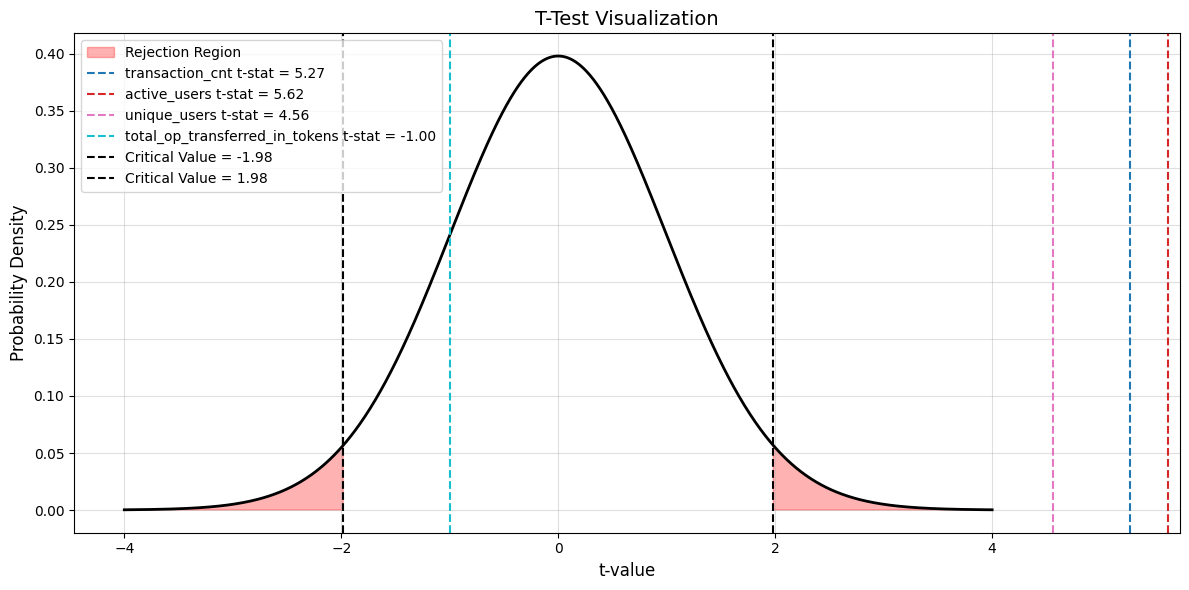

In [73]:
plot_t_test(metrics_table)